<img src="https://j.gifs.com/vO2k6P.gif" alt="Indiana Jones Plane Flying Gif"></img>

# Great Circle Arcs and Path

---

## Overview

Imagine a plane flying from Cario to Hong Kong. To a passenger, the plane appears to travel a straight path, but the plane actually curves around the surface, held down by the gravity of the planet.

Great circles are circles that circumnavigate the globe.

- Distance between Points on a Great Circle Arc
- Spherical Distance to Degrees
- Determine the Bearing of a Great Circle Arc
- Generate a Great Circle Arc with Intermediate Points
- Determine the Midpoint of a Great Circle Arc
- Generate a Great Circle Path
- Determine an Antipodal Point
- Compare Great Circle Arc to Rhumb Line (TODO)

## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Numpy](https://foundations.projectpythia.org/core/numpy.html) | Necessary | |
| [Pandas](https://foundations.projectpythia.org/core/numpy.html) | Necessary | |
| [Intro to Cartopy](https://foundations.projectpythia.org/core/cartopy/cartopy.html) | Helpful | Will be used for plotting |
| [Matplotlib](https://foundations.projectpythia.org/core/matplotlib.html) | Helpful | Will be used for plotting |

- **Time to learn**: 40 minutes

---

## Imports

- Import Packages
- Setup location dataframe with coordinates

In [5]:
import pandas as pd       # reading in data for location information from text file
import numpy as np        # working with arrays, vectors, cross/dot products, and radians

from pyproj import Geod   # working with the Earth as an ellipsod (WGS-84)
import geopy.distance     # working with the Earth as an ellipsod

In [6]:
# Get all Coordinates for Locations
location_df = pd.read_csv("../location_full_coords.txt")
location_df = location_df.rename(columns=lambda x: x.strip()) # strip excess white space from column names and values
location_df.head()

,name,latitude,longitude,cart_x,cart_y,cart_z,rho,theta,phi,polar_x,polar_y,polar_z
0,arecibo,18.3441,-66.7527,2.389526e+06,-5.562495e+06,2.007347e+06,6378137.0,-1.165054,1.250631,-5.562495e+06,2.389526e+06,2.007347e+06
1,boulder,40.0150,-105.2705,-1.286558e+06,-4.712394e+06,4.101066e+06,6378137.0,1.304276,0.872403,-4.712394e+06,-1.286558e+06,4.101066e+06
2,boston,42.3601,-71.0589,1.529809e+06,-4.457769e+06,4.297512e+06,6378137.0,-1.240212,0.831473,-4.457769e+06,1.529809e+06,4.297512e+06
3,redwoods,41.4017,-124.0417,-2.678169e+06,-3.964322e+06,4.218080e+06,6378137.0,0.976657,0.848200,-3.964322e+06,-2.678169e+06,4.218080e+06
4,houston,29.5518,-95.0982,-4.930480e+05,-5.526456e+06,3.145762e+06,6378137.0,1.481816,1.055020,-5.526456e+06,-4.930480e+05,3.145762e+06


In [7]:
location_df.index = location_df["name"]

## Distance Between Points on a Great Circle Arc

### Determine Distance Mathematically via Unit Sphere

Distance between point A (latA, lonA) and point B (latB, lonB):

$$d=acos(sin(latA)*sin(latB)+cos(latA)*cos(latB)*cos(lonA-lonB))$$

For shorter distances (with less rounding errors):

$$d=2*asin(\sqrt{sin(\frac{latA-latB}{2})^2 + cos(latA)*cos(latB)*sin(\frac{lonA-lonB}{2})^2})$$

- [Ed Williams: Distance Between Points](https://edwilliams.org/avform147.htm#Dist)

In [8]:
def distance_between_points_default(start_point=None, end_point=None):
    earth_radius = 6378137  # meters
    latA = np.deg2rad(location_df.loc[start_point, "latitude"])
    lonA = np.deg2rad(location_df.loc[start_point, "longitude"])
    latB = np.deg2rad(location_df.loc[end_point, "latitude"])
    lonB = np.deg2rad(location_df.loc[end_point, "longitude"])

    distance_default = np.arccos(np.sin(latA)*np.sin(latB)+np.cos(latA)*np.cos(latB)*np.cos(lonA-lonB))
    return distance_default * earth_radius

In [9]:
def distance_between_points_small(start_point=None, end_point=None):
    earth_radius = 6378137  # meters
    latA = np.deg2rad(location_df.loc[start_point, "latitude"])
    lonA = np.deg2rad(location_df.loc[start_point, "longitude"])
    latB = np.deg2rad(location_df.loc[end_point, "latitude"])
    lonB = np.deg2rad(location_df.loc[end_point, "longitude"])

    distance_small = 2 * np.arcsin(np.sqrt((np.sin((latA-latB)/2))**2 + np.cos(latA)*np.cos(latB)*(np.sin((lonA-lonB)/2))**2))
    return distance_small * earth_radius

Additional types of distance measuerments:
- Haversine
- Vincenty Sphere Great Circle Distance
- Vincenty Ellipsoid Great Circle Distance
- Meeus Great Circle Distance

### Determine Distance Points via Python Package `pyproj`

`pyproj` accounts for different ellipsoids like `WGS-84`.

First, setup a ellipsoid to represent the Earth ("WGS-84"):

In [10]:
# Distance between Boulder and Boston
geodesic = Geod(ellps="WGS84")
_, _, distance_meter =  geodesic.inv(location_df.loc["boulder", "longitude"],
                                     location_df.loc["boulder", "latitude"],
                                     location_df.loc["boston", "longitude"],
                                     location_df.loc["boston", "latitude"])

print(f"Distance between coordinates (ellipsoid)   = {distance_meter/1000} km")
distance_unit_sphere_default = distance_between_points_default("boulder", "boston")
print(f"Distance between coordinates (unit sphere) = {distance_unit_sphere_default/1000} km")
distance_unit_sphere_small = distance_between_points_small("boulder", "boston")
print(f"Distance between coordinates (unit sphere) = {distance_unit_sphere_small/1000} km")

Distance between coordinates (ellipsoid)   = 2862.597479914522 km
Distance between coordinates (unit sphere) = 2858.532213639344 km
Distance between coordinates (unit sphere) = 2858.5322136393447 km


Compared to the distance from the associated airports in Denver and Boston ([DIA to Logan](https://www.greatcirclemap.com/?routes=DEN-BOS)) which has a distance of 2823 km, using Denver instead of Boulder.

## Spherical Distance to Degrees

Convert a distance from meters to degrees, measured along the great circle sphere with a constant spherical radius of ~6371 km (mean radius of Earth).

- See also: [ObsPy `kilometer2degrees()`](https://docs.obspy.org/packages/autogen/obspy.geodetics.base.kilometer2degrees.html)

In [11]:
# assumes a spherical Earth
earth_radius = 6378.137 # km

def km_to_degree_distance(distance_km=None):
    return distance_km / (2 * earth_radius * np.pi / 360)

def degree_to_km_distance(distance_degree=None):
    return distance_degree * (2 * earth_radius * np.pi / 360)

In [12]:
print(f"300 km to degrees = {km_to_degree_distance(300)} degrees")
print(f"6.381307 degree to km = {degree_to_km_distance(6.381307)} km")

300 km to degrees = 2.6949458523585643 degrees
6.381307 degree to km = 710.3638458355522 km


## Determine the Bearing of a Great Circle Arc

### Determine the Bearing Mathematically via Unit Sphere

Bearing between point A (latA, lonA) and point B (latB, lonB):

$$x = cos(latA) * sin(latB) - sin(latA) * cos(latB) * cos(lonB - lonA)$$
$$y = sin(lonB - lonA) * cos(latB)$$
$$θ = atan2(y, x)$$

- [Movable Type: Bearing](https://www.movable-type.co.uk/scripts/latlong.html#bearing)

In [20]:
def bearing_between_points_unit_sphere(start_point=None, end_point=None):
    latA = np.deg2rad(location_df.loc[start_point, "latitude"])
    lonA = np.deg2rad(location_df.loc[start_point, "longitude"])
    latB = np.deg2rad(location_df.loc[end_point, "latitude"])
    lonB = np.deg2rad(location_df.loc[end_point, "longitude"])

    x = np.cos(latA) * np.sin(latB) - np.sin(latA) * np.cos(latB) * np.cos(lonB - lonA)
    y = np.sin(lonB - lonA) * np.cos(latB)
    bearing = np.arctan2(y, x)
    return np.rad2deg(bearing) % 360

### Determine the Bearing via Python Package `pyproj`

`pyproj` accounts for different ellipsoids like `WGS-84`:

In [21]:
def bearing_between_points_ellps(start_point=None, end_point=None):
    geodesic = Geod(ellps="WGS84")
    fwd_bearing, _, _ =  geodesic.inv(location_df.loc[start_point, "longitude"],
                                        location_df.loc[start_point, "latitude"],
                                        location_df.loc[end_point, "longitude"],
                                        location_df.loc[end_point, "latitude"])
    return fwd_bearing

In [22]:
### Compare Unit Sphere and Ellipsoid
beaing_ellps = bearing_between_points_ellps("boulder", "boston")
print(f"forward bearing between coordinates (ellipsoid)   = {beaing_ellps} Degrees")
bearing_us = bearing_between_points_unit_sphere("boulder", "boston")
print(f"forward bearing between coordinates (unit sphere) = {bearing_us} Degrees")

forward bearing between coordinates (ellipsoid)   = 73.51048829569024 Degrees
forward bearing between coordinates (unit sphere) = 73.49180375272644 Degrees


## Generating a Great Circle Arc with Intermediates Points

### Determine Intermediate Points Mathemetically via Unit Sphere
Determine the points (lat, lon) a given fraction of a distance (d) between a starting points A (latA, lonA) and the final point B (latB, lonB) where f is a fraction along the great circle arc. `f=0` is point A and `f=1` is point B.

> Note: The points cannot be antipodal because the path is undefined

Where, antipodal is defined by:
$$latA + latB = 0$$
$$abs(lonA - lonB) = pi$$

Where the distance between two points is the angular distance:

$$d = \frac{\text{total distance of arc}}{\text{earth's radius}}$$

The intermediate points (lat, lon) along a given path starting point to end point:

$$A = sin(\frac{(1-f) * d}{sin(d)}$$
$$B = \frac{sin(f*d)}{sin(d)}$$
$$x = A * cos(latA) * cos(lonA) + B * cos(latB) * cos(lonB)$$
$$y = A * cos(latA) * sin(lonA) + B * cos(latB) * sin(lonB)$$
$$z = A * sin(latA) + B * sin(latB)$$
$$lat = atan2(z, \sqrt{x^2 + y^2})$$
$$lon = atan2(y, x)$$

- [Ed Williams: Intermediate Points on a Great Circle](https://edwilliams.org/avform147.htm#Intermediate)
- [Moveable Type: Intermediate Point](https://www.movable-type.co.uk/scripts/latlong.html#intermediate-point)

In [23]:
def intermediate_points(start_point=None, end_point=None,
                        fraction=None, distance=None):
    earth_radius = 6378137  # meters
    total_distance = distance / earth_radius
    latA = np.deg2rad(location_df.loc[start_point, "latitude"])
    lonA = np.deg2rad(location_df.loc[start_point, "longitude"])
    latB = np.deg2rad(location_df.loc[end_point, "latitude"])
    lonB = np.deg2rad(location_df.loc[end_point, "longitude"])

    A = np.sin((1-fraction) * total_distance) / np.sin(total_distance)
    B = np.sin(fraction * total_distance) / np.sin(total_distance)
    x = (A * np.cos(latA) * np.cos(lonA)) + (B * np.cos(latB) * np.cos(lonB))
    y = (A * np.cos(latA) * np.sin(lonA)) + (B * np.cos(latB) * np.sin(lonB))
    z = (A * np.sin(latA)) + (B * np.sin(latB))
    lat = np.arctan2(z, np.sqrt(x**2 + y**2))
    lon = np.arctan2(y, x)
    return (np.rad2deg(lat), np.rad2deg(lon))

def calculate_intermediate_pts(start_point=None, end_point=None,
                               fraction=None, total_distance_meter=None):
    fractions = np.arange(0, 1+fraction, fraction)
    intermediate_lat_lon = []
    for fractional in fractions:
        intermediate_pts = intermediate_points(start_point, end_point,
                                                fractional, total_distance_meter)
        intermediate_lat_lon.append(intermediate_pts)
    return intermediate_lat_lon

### Determine Intermediate Points via Python Package `pyproj` and `geopy`

1. Interpolate with N total equally spaced number of points
2. Interpolate every N meters
3. Interpolate a fractional distance along arc

In [24]:
def interpolate_points_along_gc(lat_start,
                                lon_start,
                                lat_end,
                                lon_end,
                                distance_between_points_meter): 
    lat_lon_points = [(lat_start, lon_start)]
    
    # move to next point when distance between points is less than the equal distance
    move_to_next_point = True
    while(move_to_next_point):
        forward_bearing, _, distance_meters = geodesic.inv(lon_start,
                                                            lat_start, 
                                                            lon_end,
                                                            lat_end)
        if distance_meters < distance_between_points_meter:
            # ends before overshooting
            move_to_next_point = False
        else:
            start_point = geopy.Point(lat_start, lon_start)
            distance_to_move = geopy.distance.distance(
                            kilometers=distance_between_points_meter /
                            1000)  # distance to move towards the next point
            final_position = distance_to_move.destination(
                            start_point, bearing=forward_bearing)
            lat_lon_points.append((final_position.latitude, final_position.longitude))
            # new starting position is newly found end position
            lon_start, lat_start = final_position.longitude, final_position.latitude
    lat_lon_points.append((lat_end, lon_end))
    return lat_lon_points

### Plot Arcs as Points on a World Map

In [25]:
import matplotlib.pyplot as plt
from cartopy import crs as ccrs, feature as cfeature

def plot_coordinate(lst_of_coords=None, title=None):
    # Set up world map plot on the United States
    fig = plt.subplots(figsize=(15, 10))
    projection_map = ccrs.PlateCarree()
    ax = plt.axes(projection=projection_map)
    lon_west, lon_east, lat_south, lat_north = -130, -60, 20, 60
    ax.set_extent([lon_west, lon_east, lat_south, lat_north], crs=projection_map)
    ax.coastlines(color="black")
    ax.add_feature(cfeature.STATES, edgecolor="black")
    
    # Plot Latitude/Longitude Location
    longitudes = [x[1] for x in lst_of_coords] # longitude
    latitudes = [x[0] for x in lst_of_coords] # latitude
    plt.plot(longitudes, latitudes)
    plt.scatter(longitudes, latitudes)
    
    # Setup Axis Limits and Title/Labels
    plt.title(title)
    plt.show()

#### Interpolate with N Total Equally Spaced Points

In [26]:
n_total_points = 10 # total points (n points)
distance_between_points_meter = distance_meter / (n_total_points + 1)
print(f"Each point will be separated by {distance_between_points_meter} meters ({distance_between_points_meter/1000} km)")

Each point will be separated by 260236.1345376838 meters (260.2361345376838 km)


In [27]:
lat_start, lon_start = location_df.loc[["boulder"]]["latitude"].iloc[0], location_df.loc[["boulder"]]["longitude"].iloc[0]
lat_end, lon_end = location_df.loc[["boston"]]["latitude"].iloc[0], location_df.loc[["boston"]]["longitude"].iloc[0]

intermediate_geodesic = interpolate_points_along_gc(lat_start,
                                          lon_start,
                                          lat_end,
                                          lon_end,
                                          distance_between_points_meter)
print(f"{len(intermediate_geodesic)} Total Points")
intermediate_geodesic

12 Total Points


[(40.015, -105.2705),
 (40.64283438472448, -102.32002071588883),
 (41.19386139956729, -99.31719425393653),
 (41.665293789240074, -96.2672998277903),
 (42.054648659580415, -93.17653047007545),
 (42.35980367525436, -90.05192021556941),
 (42.57904824130258, -86.90123344627509),
 (42.711126897374584, -83.73281874084785),
 (42.75527239726805, -80.55543262504408),
 (42.71122644219359, -77.37804142647052),
 (42.57924674954763, -74.20961159223958),
 (42.3601, -71.0589)]

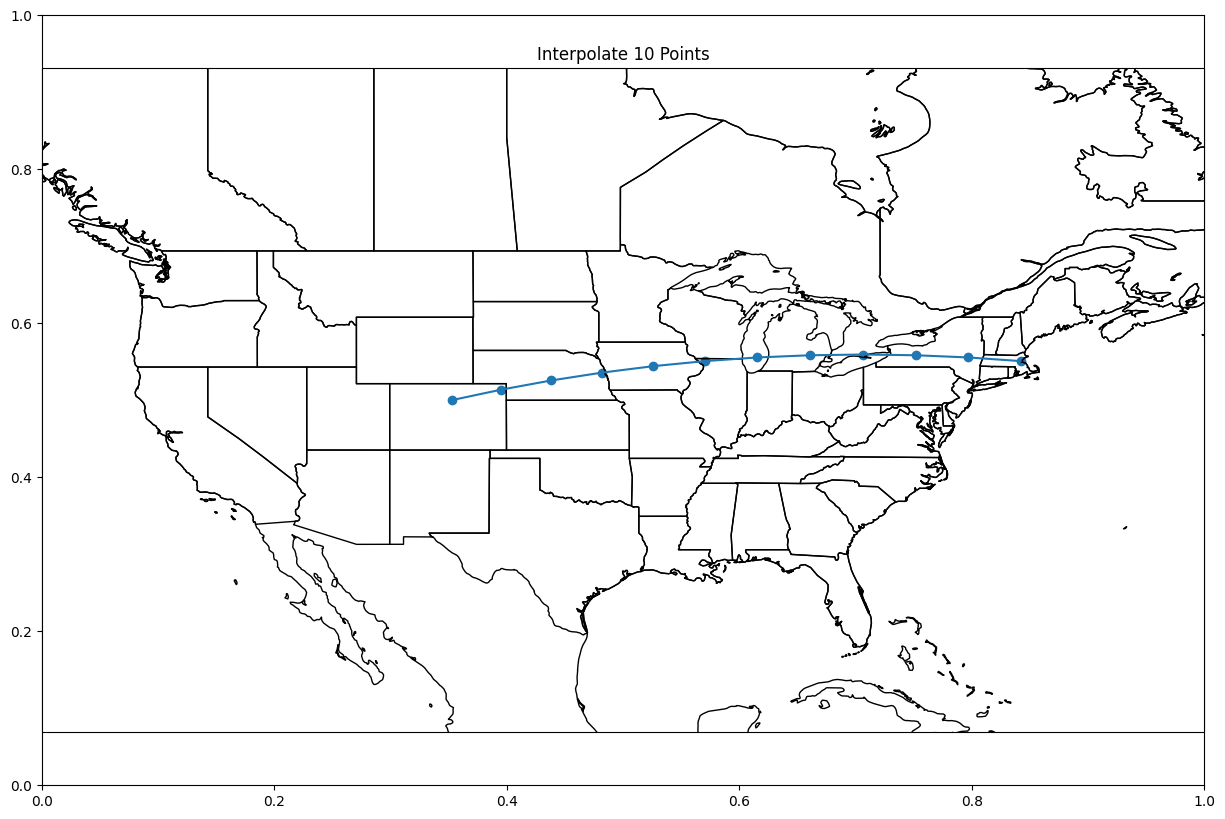

In [28]:
plot_coordinate(intermediate_geodesic,
                title=f"Interpolate {n_total_points} Points")

#### Interpolate every N meters

In [29]:
distance_between_points_meter = 112000
print(f"Each point will be separated by {distance_between_points_meter} meters ({distance_between_points_meter/1000} km)")

Each point will be separated by 112000 meters (112.0 km)


In [30]:
lat_start, lon_start = location_df.loc["boulder", "latitude"], location_df.loc["boulder", "longitude"]
lat_end, lon_end = location_df.loc["boston", "latitude"], location_df.loc["boston", "longitude"]

intermediate_geodesic = interpolate_points_along_gc(lat_start,
                                          lon_start,
                                          lat_end,
                                          lon_end,
                                          distance_between_points_meter)
print(f"{len(intermediate_geodesic)} Total Points")
intermediate_geodesic

27 Total Points


[(40.015, -105.2705),
 (40.2944315242048, -104.00739372929635),
 (40.55994883031887, -102.73410083358552),
 (40.8113122094977, -101.45097760323465),
 (41.0482901063323, -100.1584131314004),
 (41.27065999040771, -98.85682902091183),
 (41.478209225696254, -97.54667886388198),
 (41.6707359307123, -96.22844748540263),
 (41.84804982201719, -94.90264994540802),
 (42.00997303342117, -93.56983029584391),
 (42.15634090309507, -92.23056009359968),
 (42.287002720790326, -90.88543667319327),
 (42.40182242747838, -89.5350811868695),
 (42.50067925996674, -88.18013642349814),
 (42.583468333429785, -86.82126442135146),
 (42.65010115530706, -85.45914389340658),
 (42.70050606466465, -84.09446748716027),
 (42.73462859187762, -82.72793890397026),
 (42.75243173435998, -81.36026990555978),
 (42.75389614502746, -79.99217723746457),
 (42.73902023120852, -78.624379500797),
 (42.707820162798164, -77.2575940047039),
 (42.66032978955508, -75.8925336322703),
 (42.59660046855048, -74.52990375235942),
 (42.516700803

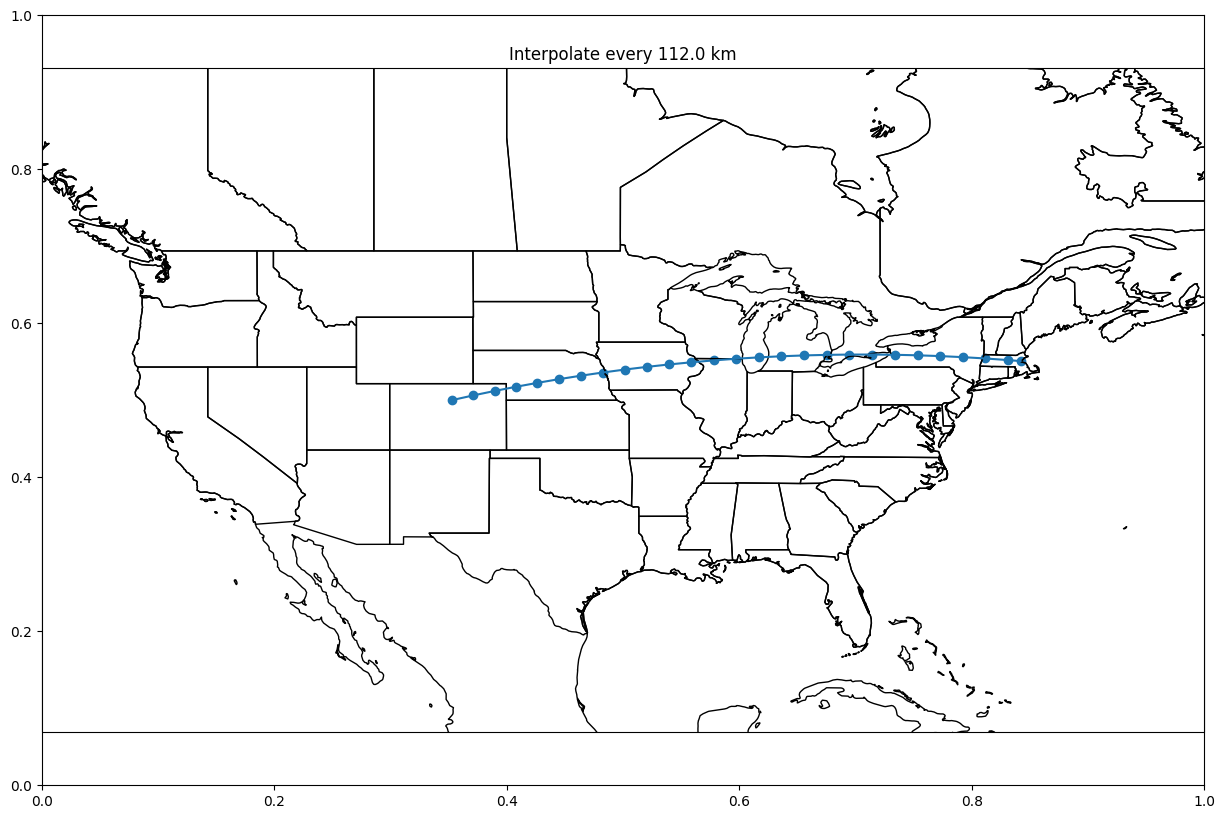

In [31]:
plot_coordinate(intermediate_geodesic,
                title=f"Interpolate every {distance_between_points_meter/1000} km")

#### Interpolate a fractional distance along arc

In [34]:
fraction = 1/10

In [35]:
distance_between_points_meter = fraction * distance_meter
print(f"Each point will be separated by {distance_between_points_meter} meters ({distance_between_points_meter/1000} km)")

Each point will be separated by 286259.74799145217 meters (286.2597479914522 km)


In [36]:
lat_start, lon_start = location_df.loc["boulder", "latitude"], location_df.loc["boulder", "longitude"]
lat_end, lon_end = location_df.loc["boston", "latitude"], location_df.loc["boston", "longitude"]

intermediate_ellipsoid = interpolate_points_along_gc(lat_start,
                                          lon_start,
                                          lat_end,
                                          lon_end,
                                          distance_between_points_meter)
print(f"{len(intermediate_ellipsoid)} Total Points")
intermediate_ellipsoid

11 Total Points


[(40.015, -105.2705),
 (40.70144152851926, -102.0220139666611),
 (41.29459964930597, -98.7107954391427),
 (41.790822409112124, -95.34405626799516),
 (42.18692017366623, -91.93032741511365),
 (42.4802543416051, -88.47932636547252),
 (42.66881568690329, -85.00175846666659),
 (42.75128706952139, -81.50905885116296),
 (42.72708599453554, -78.01308797522954),
 (42.59638380227174, -74.52579917182065),
 (42.3601, -71.0589)]

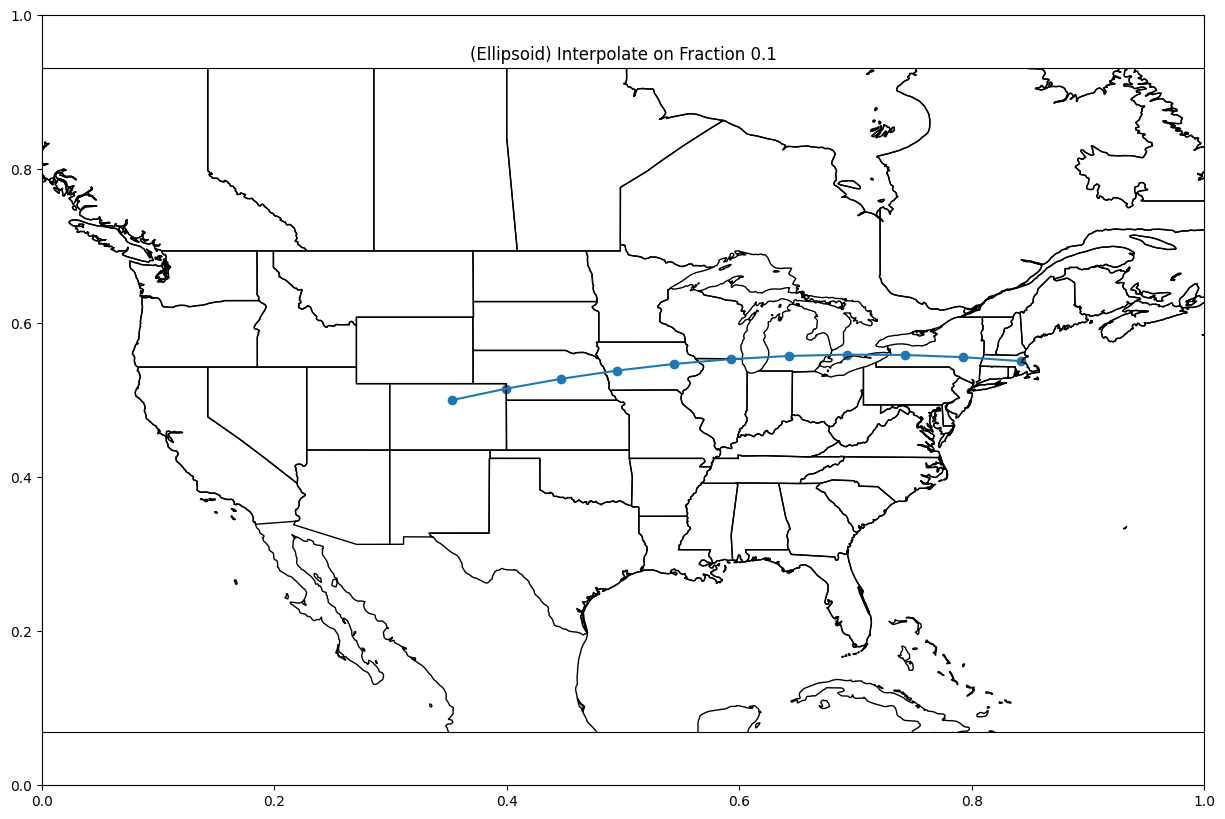

In [37]:
plot_coordinate(intermediate_ellipsoid,
                title=f"(Ellipsoid) Interpolate on Fraction {fraction}")

In [38]:
distance_unit_sphere_default = distance_between_points_default("boulder", "boston")
intermediate_unit_sphere = calculate_intermediate_pts("boulder", "boston",
                                               fraction, distance_unit_sphere_default)
print(f"{len(intermediate_unit_sphere)} Total Points")
intermediate_unit_sphere

11 Total Points


[(40.015, -105.2705),
 (40.69956840796515, -102.0224051615289),
 (41.291305596308824, -98.71150732723615),
 (41.786544424077, -95.3450112546059),
 (42.1820804843035, -91.93144054027105),
 (42.475261312703864, -88.48050569778584),
 (42.66406520473303, -85.00290620334833),
 (42.74716436193266, -81.51007310432796),
 (42.723967826794556, -78.01386515980239),
 (42.59464096704978, -74.52623685097386),
 (42.3601, -71.0589)]

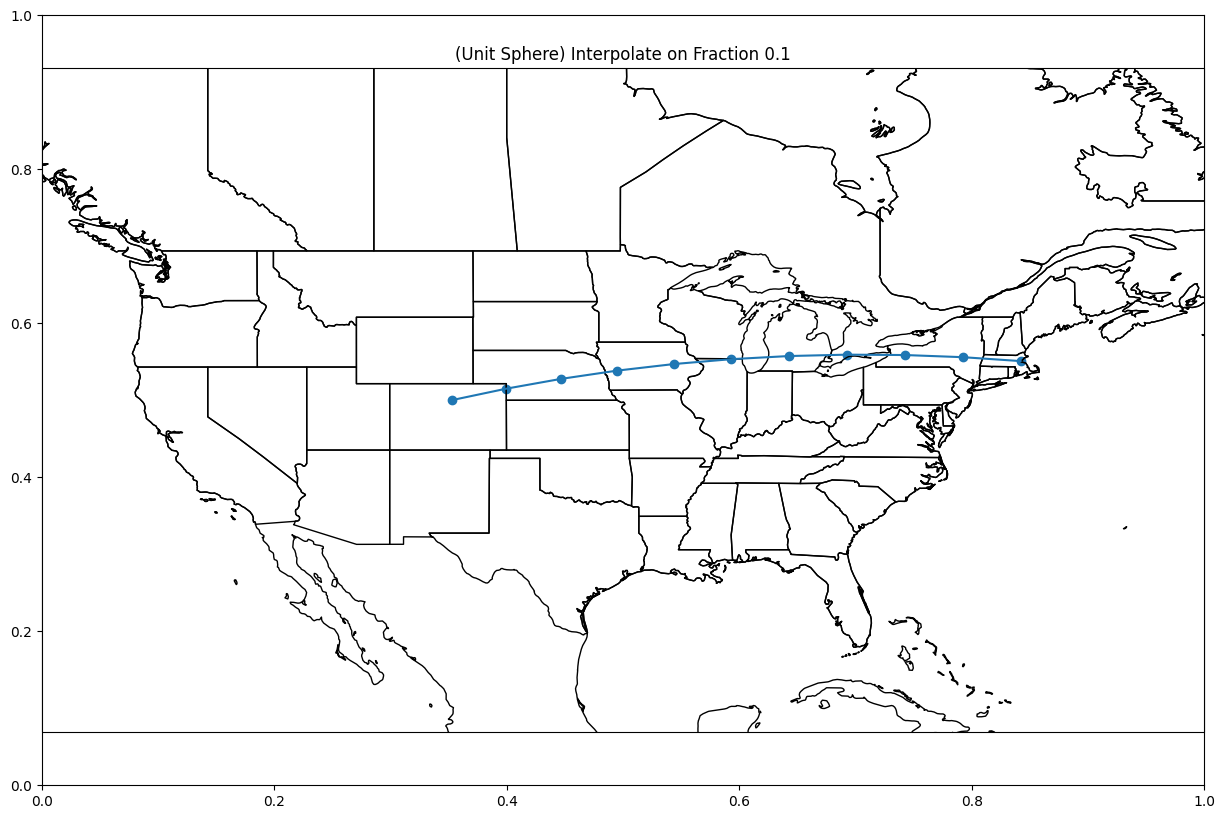

In [39]:
plot_coordinate(intermediate_unit_sphere,
                title=f"(Unit Sphere) Interpolate on Fraction {fraction}")

In [40]:
# compare math and geodesic outputs
for i in range(len(intermediate_ellipsoid)):
    _, _, distance_m = geodesic.inv(intermediate_ellipsoid[i][0], intermediate_ellipsoid[i][1],
                                   intermediate_unit_sphere[i][0], intermediate_unit_sphere[i][1])
    if np.isnan(distance_m): distance_m = 0
    print(f"Distance between ellipsoid/unit sphere defined point {i}: {distance_m} meters")

Distance between ellipsoid/unit sphere defined point 0: 0 meters
Distance between ellipsoid/unit sphere defined point 1: 0 meters
Distance between ellipsoid/unit sphere defined point 2: 0 meters
Distance between ellipsoid/unit sphere defined point 3: 0 meters
Distance between ellipsoid/unit sphere defined point 4: 0 meters
Distance between ellipsoid/unit sphere defined point 5: 132.55154860346607 meters
Distance between ellipsoid/unit sphere defined point 6: 136.26443374190515 meters
Distance between ellipsoid/unit sphere defined point 7: 132.0972186845727 meters
Distance between ellipsoid/unit sphere defined point 8: 112.95654352480192 meters
Distance between ellipsoid/unit sphere defined point 9: 71.2918632650005 meters
Distance between ellipsoid/unit sphere defined point 10: 0.0 meters


## Determine the Midpoint of a Great Circle Arc

The midpoint of an arc can be determiend as a fractional distance along an arc where f = 0.5.

In [41]:
midpoint = distance_meter / 2
lat_start, lon_start = location_df.loc["boulder", "latitude"], location_df.loc["boulder", "longitude"]
lat_end, lon_end = location_df.loc["boston", "latitude"], location_df.loc["boston", "longitude"]

intermediate_geodesic = interpolate_points_along_gc(lat_start,
                                          lon_start,
                                          lat_end,
                                          lon_end,
                                          midpoint)
print(f"{len(intermediate_geodesic)} Total Points")
print(intermediate_geodesic)
print(f"Midpoint = {intermediate_geodesic[1]}")

3 Total Points
[(40.015, -105.2705), (42.48025434160511, -88.4793263654725), (42.3601, -71.0589)]
Midpoint = (42.48025434160511, -88.4793263654725)


In [340]:
distance_unit_sphere_default = distance_between_points_default("boulder", "boston")
intermediate_unit_sphere = calculate_intermediate_pts("boulder", "boston",
                                               1/2, distance_unit_sphere_default)
print(f"{len(intermediate_unit_sphere)} Total Points")
print(intermediate_unit_sphere)
print(f"Midpoint = {intermediate_unit_sphere[1]}")

3 Total Points
[(40.015, -105.2705), (42.475261312703864, -88.48050569778584), (42.3601, -71.0589)]
Midpoint = (42.475261312703864, -88.48050569778584)


In [341]:
# Compare geodesic and unit sphere
_, _, distance_m = geodesic.inv(intermediate_geodesic[1][0], intermediate_geodesic[1][1],
                                   intermediate_unit_sphere[1][0], intermediate_unit_sphere[1][1])
print(f"Distance between geodesic/unint sphere defined midpoint = {distance_m} meters")

Distance between geodesic/unint sphere defined midpoint = 132.5515486050814 meters


## Generate a Great Circle Path

Get points on the Great Cricle defined by two points.

In [42]:
# Generate Latitude Coordinates based on Longitude Coordinates
def generate_latitude_along_gc(start_point=None, end_point=None, number_of_lon_pts=360):
    lat1 = np.deg2rad(location_df.loc[start_point, "latitude"])
    lon1 = np.deg2rad(location_df.loc[start_point, "longitude"])
    lat2 = np.deg2rad(location_df.loc[end_point, "latitude"])
    lon2 = np.deg2rad(location_df.loc[end_point, "longitude"])

    # Verify not meridian (longitude passes through the poles)
    if np.sin(lon1 - lon2) == 0:
        print("Invalid inputs: start/end points are meridians")
        # plotting meridians at 0 longitude through all latitudes
        meridian_lat = np.arange(-90, 90, 180/len(longitude_lst)) # split in n number
        meridians = []
        for lat in meridian_lat:
            meridians.append((lat, 0))
        return meridians

    # verify not anitpodal (diametrically opposite, points)
    if lat1 + lat2 == 0 and abs(lon1-lon2) == np.pi:
        print("Invalid inputs: start/end points are antipodal")
        return []

    # note: can be expanded to handle input of np arrays by filter out antipodal/merdiain points

    # generate n total number of longitude points along the great circle
    # https://github.com/rspatial/geosphere/blob/master/R/greatCircle.R#L18C3-L18C7
    gc_lon_lst = []
    for lon in range(1, number_of_lon_pts+1):
        new_lon = (lon  * (360/number_of_lon_pts) - 180)
        gc_lon_lst.append(np.deg2rad(new_lon))

    # Intermediate points on a great circle: https://edwilliams.org/avform147.htm"
    gc_lat_lon = []
    for gc_lon in gc_lon_lst:
        num = np.sin(lat1)*np.cos(lat2)*np.sin(gc_lon-lon2)-np.sin(lat2)*np.cos(lat1)*np.sin(gc_lon-lon1)
        den = np.cos(lat1)*np.cos(lat2)*np.sin(lon1-lon2)
        new_lat = np.arctan(num/den)
        gc_lat_lon.append((np.rad2deg(new_lat), np.rad2deg(gc_lon)))
    return gc_lat_lon

In [43]:
def arc_points(start_lat=None,
               start_lon=None,
               end_lat=None,
               end_lon=None,
               n_total_points=10):
    _, _, distance_meter =  geodesic.inv(start_lon,
                                        start_lat,
                                        end_lon,
                                        end_lat)
        
    distance_between_points_meter = distance_meter / (n_total_points + 1)

    
    points_along_arc = interpolate_points_along_gc(start_lat,
                                              start_lon,
                                              end_lat,
                                              end_lon,
                                              distance_between_points_meter)
    return points_along_arc

In [44]:
def plot_coordinate(lat_lon_lst=None,
                    start_point=None, end_point=None,
                    title=None):
    # Set up world map plot
    fig = plt.subplots(figsize=(15, 10))
    projection_map = ccrs.PlateCarree()
    ax = plt.axes(projection=projection_map)
    lon_west, lon_east, lat_south, lat_north = -180, 180, -90, 90
    ax.set_extent([lon_west, lon_east, lat_south, lat_north], crs=projection_map)
    ax.coastlines(color="black")
    ax.add_feature(cfeature.BORDERS, edgecolor='grey')
    ax.add_feature(cfeature.STATES, edgecolor="grey")
        
    # Plot Latitude/Longitude Location of great circle path
    longitudes = [x[1] for x in lat_lon_lst] # longitude
    latitudes = [x[0] for x in lat_lon_lst] # latitude
    plt.plot(longitudes, latitudes, c="cornflowerblue")
    plt.scatter(longitudes, latitudes, c="cornflowerblue")

    # Overly great circle with arc rom start/end point
    start_end_lat_lon = arc_points(location_df.loc[start_point, "latitude"],
                                   location_df.loc[start_point, "longitude"],
                                   location_df.loc[end_point, "latitude"],
                                   location_df.loc[end_point, "longitude"],
                                   n_total_points=20)
    longitudes = [x[1] for x in start_end_lat_lon] # longitude
    latitudes = [x[0] for x in start_end_lat_lon] # latitude
    plt.plot(longitudes, latitudes, c="red")
    plt.scatter(longitudes, latitudes, c="red")
    
    # Setup Axis Limits and Title/Labels
    plt.title(title)
    plt.show()

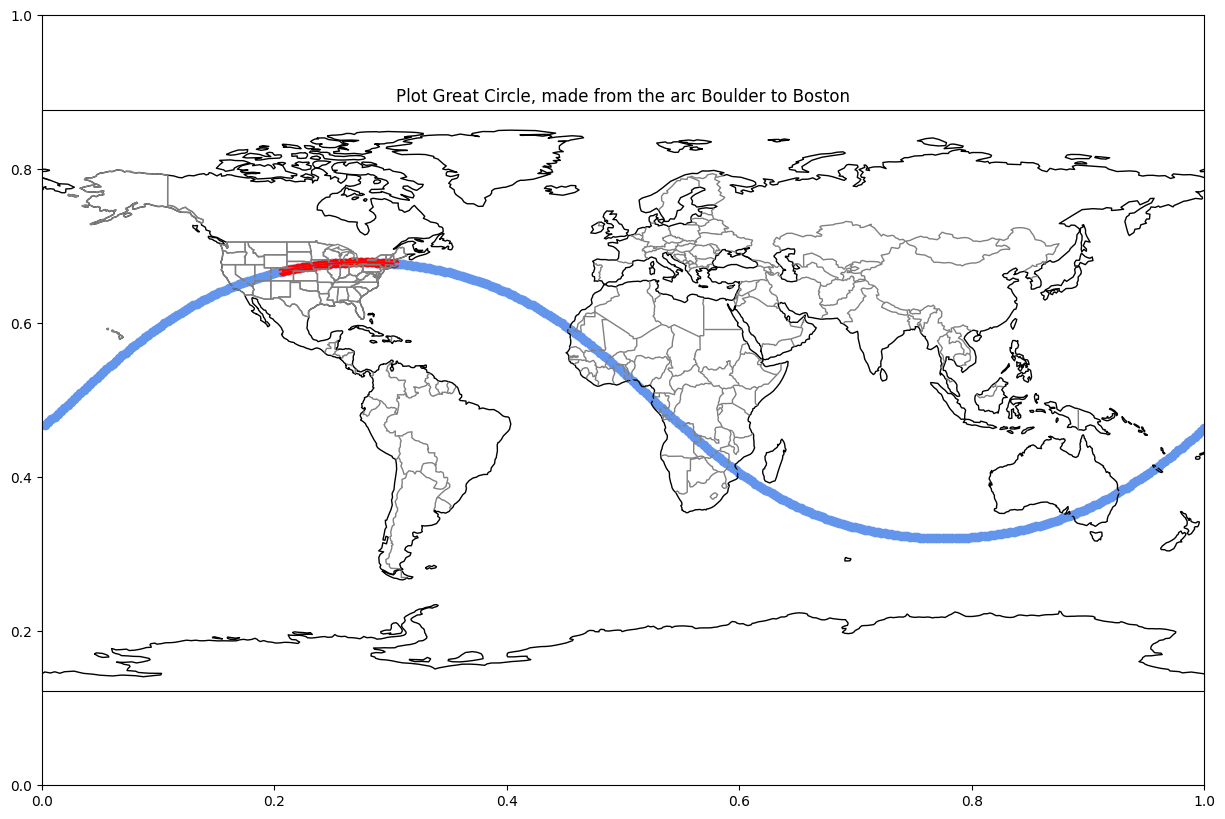

In [45]:
start_pt = "boulder"
end_pt = "boston"
n_pts = 360
lat_lon_pts = generate_latitude_along_gc(start_pt, end_pt, number_of_lon_pts=n_pts)
plot_coordinate(lat_lon_pts, start_pt, end_pt,
                f"Plot Great Circle, made from the arc {start_pt.title()} to {end_pt.title()}")

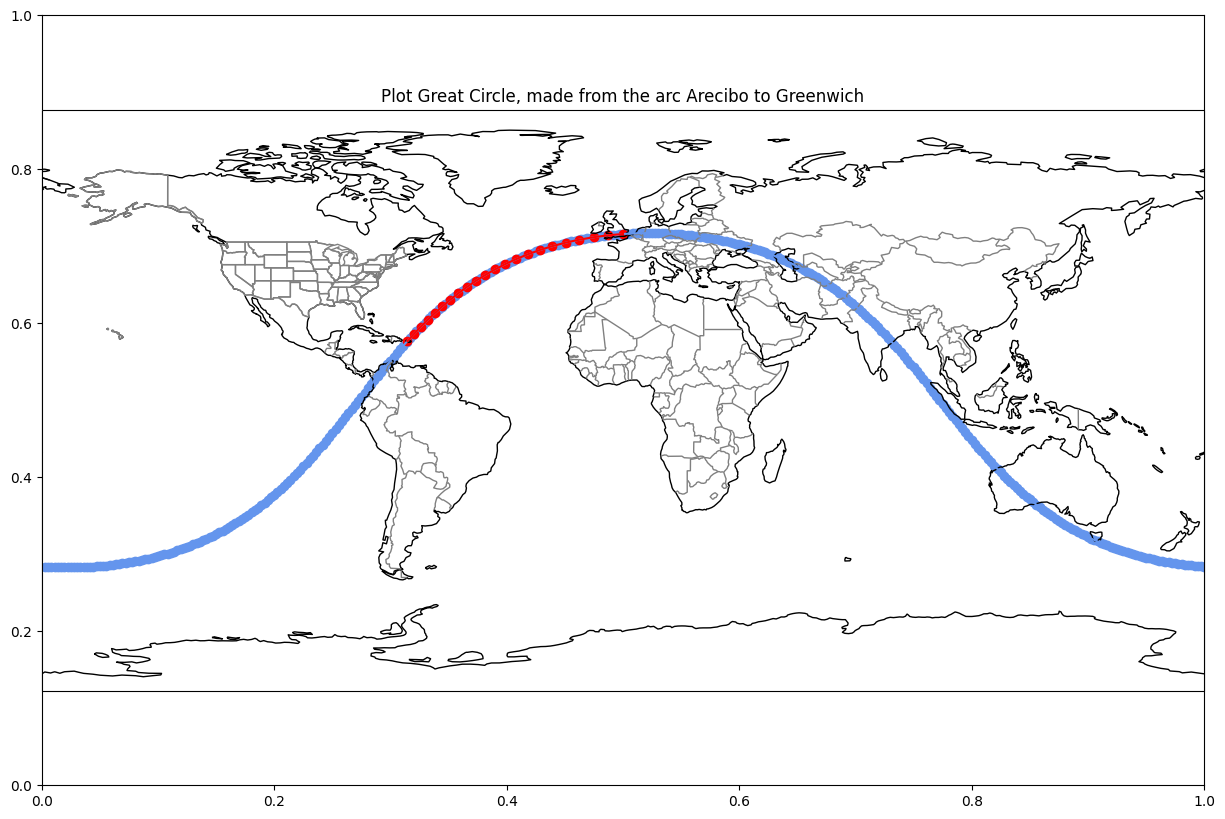

In [46]:
start_pt = "arecibo"
end_pt = "greenwich"
n_pts = 360
lat_lon_pts = generate_latitude_along_gc(start_pt, end_pt, number_of_lon_pts=n_pts)
plot_coordinate(lat_lon_pts, start_pt, end_pt,
                f"Plot Great Circle, made from the arc {start_pt.title()} to {end_pt.title()}")

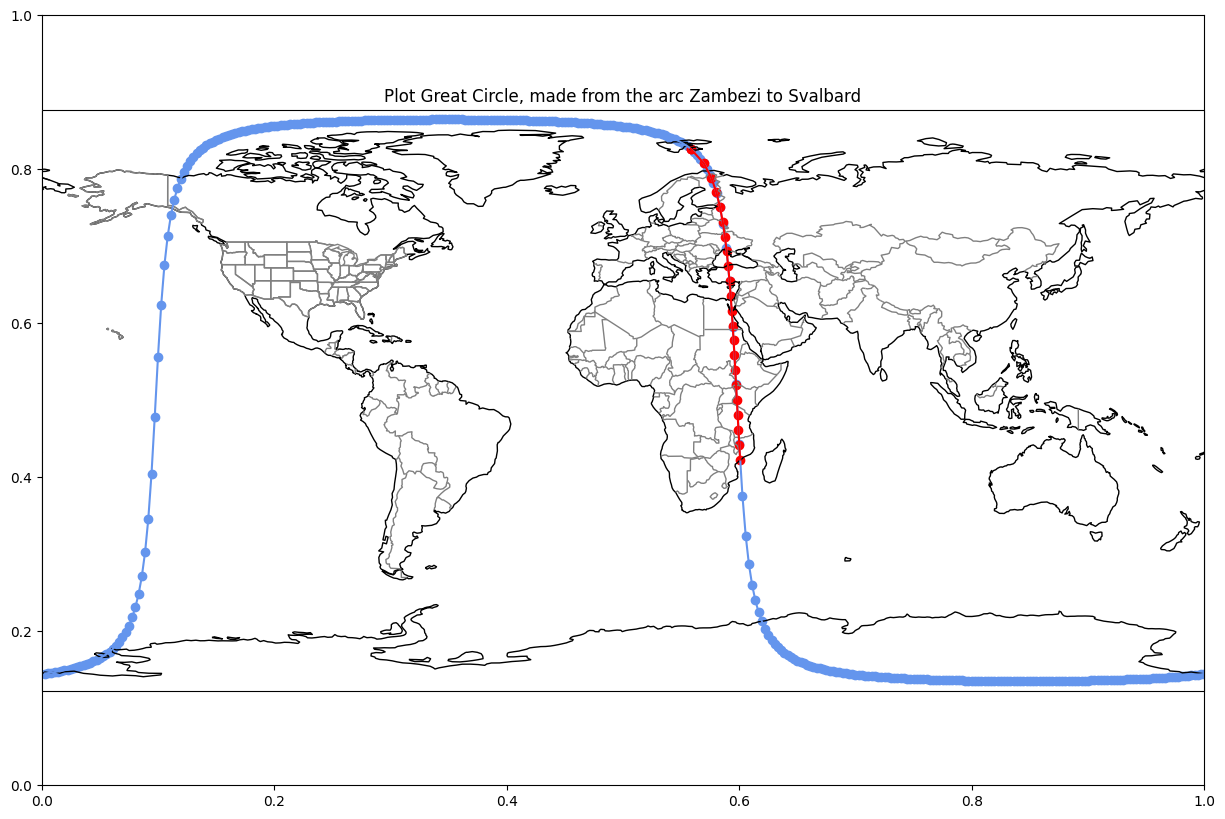

In [47]:
start_pt = "zambezi"
end_pt = "svalbard"
n_pts = 360
lat_lon_pts = generate_latitude_along_gc(start_pt, end_pt, number_of_lon_pts=n_pts)
plot_coordinate(lat_lon_pts, start_pt, end_pt,
                f"Plot Great Circle, made from the arc {start_pt.title()} to {end_pt.title()}")

## Determine an Antipodal Point

Antipodal is the point on the globe that is on the exact opposite side of the Earth.

Antipodal latitude is defined as:

$$\text{antipodal latitude} = -1 * \text{latitude}$$

Antipodal longitude is defined as:

$$\text{anitpodal longitude} = (\text{longitude} + 180) \text{ if longitude} \le 0$$
$$\text{anitpodal longitude} = (\text{longitude} - 180) \text{ if longitude} \gt 0$$

- [Antipodes Map](https://www.antipodesmap.com/)

In [51]:
def antipodal(start_point=None):
    anti_lat = -1 * location_df.loc[start_point, "latitude"]
    ref_lon = location_df.loc[start_point, "longitude"]
    if ref_lon > 0:
        anti_lon = ref_lon - 180
    else:
        anti_lon = ref_lon + 180
    #if anti_lon >= 180:
    #    anti_lon = -1 * (anti_lon % 180)
    return (anti_lat, anti_lon)

In [52]:
def is_antipodal(start_point=None, end_point=None):
    lon1 = np.deg2rad(location_df.loc[start_point, "longitude"])
    lat1 = np.deg2rad(location_df.loc[start_point, "latitude"])
    lon2 = np.deg2rad(location_df.loc[end_point, "longitude"])
    lat2 = np.deg2rad(location_df.loc[end_point, "latitude"])
    return lat1 + lat2 == 0 and abs(lon1-lon2) == np.pi

In [53]:
def plot_antipodal(start_point=None):
    # Set up world map plot
    fig = plt.subplots(figsize=(15, 10))
    projection_map = ccrs.PlateCarree()
    ax = plt.axes(projection=projection_map)
    lon_west, lon_east, lat_south, lat_north = -180, 180, -90, 90
    ax.set_extent([lon_west, lon_east, lat_south, lat_north], crs=projection_map)
    ax.coastlines(color="black")
    ax.add_feature(cfeature.BORDERS, edgecolor='grey')
    ax.add_feature(cfeature.STATES, edgecolor="grey")
        
    # Plot Start point
    plt.scatter(location_df.loc[start_point, "longitude"],
                location_df.loc[start_point, "latitude"],
                s=100, c="cornflowerblue", label=start_point.title())

    # Plot Antipodal Point
    antipodal_point = antipodal(start_point)
    plt.scatter(antipodal_point[1], antipodal_point[0], s=100, c="red", label="Antipodal")
    
    # Setup Axis Limits and Title/Labels
    plt.title(f"{start_point.title()} and Antipodal Point {antipodal_point}")
    plt.legend(loc="lower right")
    plt.show()

(-40.015, 74.7295)


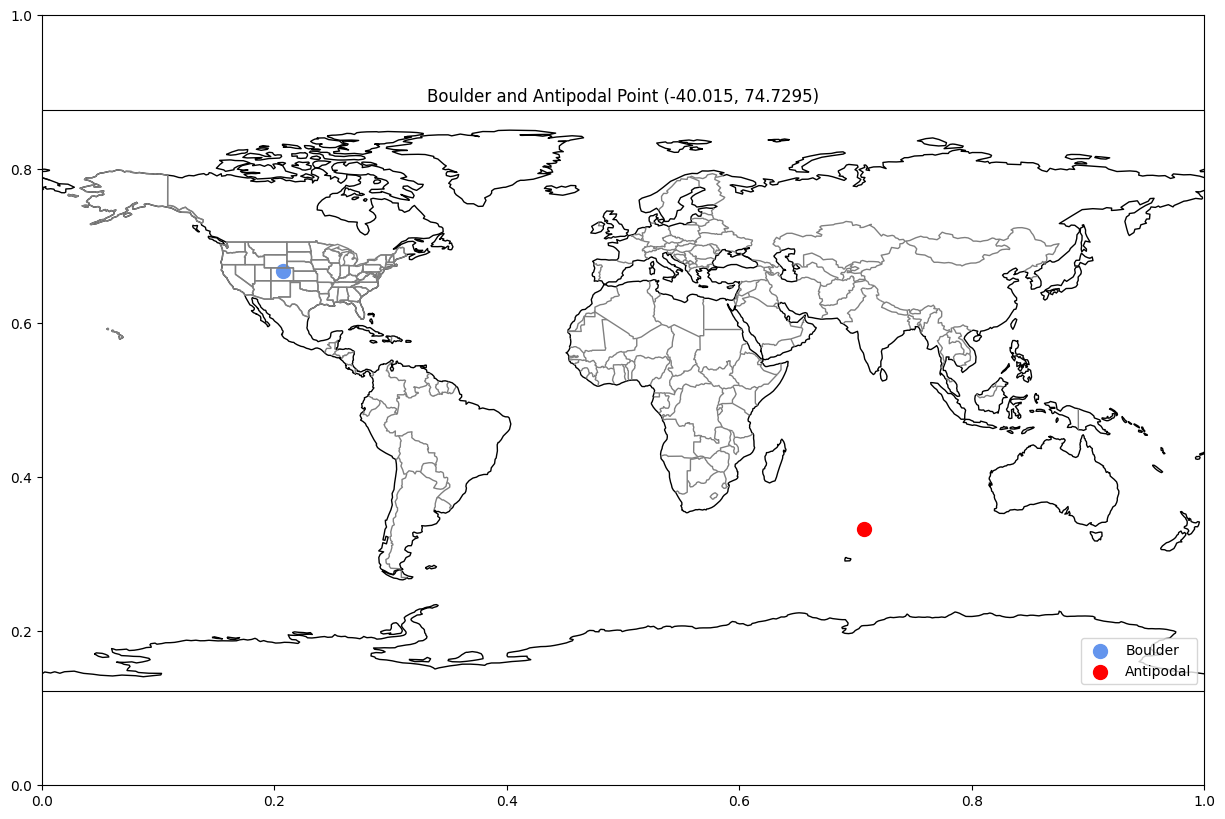

In [54]:
print(antipodal("boulder"))
plot_antipodal("boulder")

(-77.875, -159.0248)


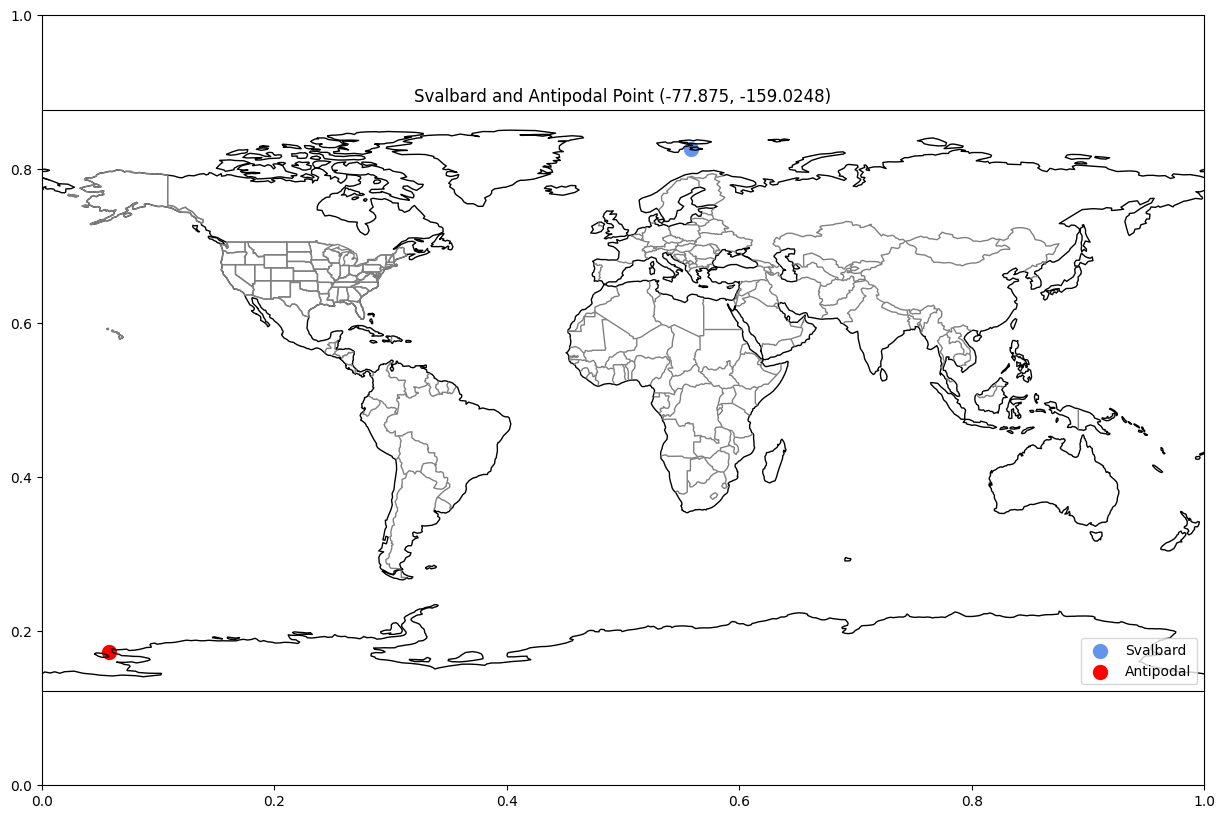

In [55]:
print(antipodal("svalbard"))
plot_antipodal("svalbard")

(-30.0444, -148.7643)


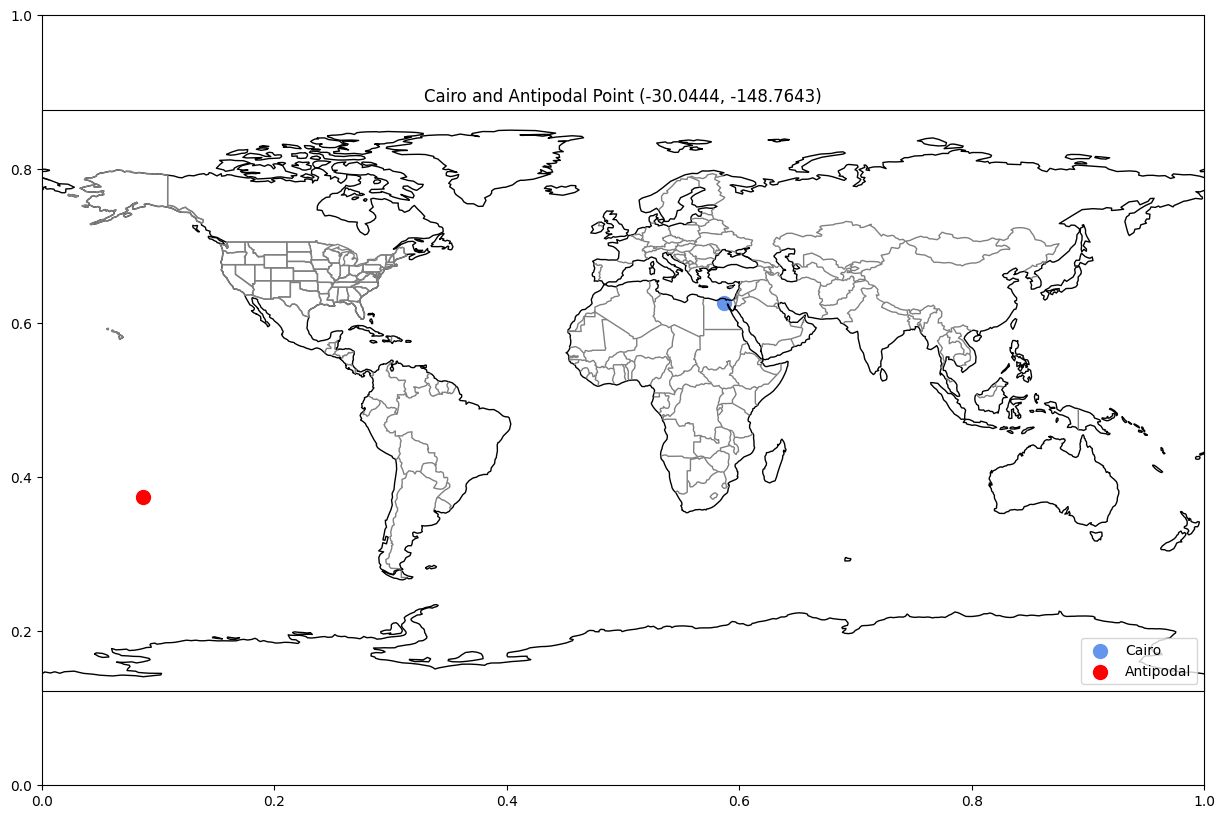

In [56]:
print(antipodal("cairo"))
plot_antipodal("cairo")

---

## Summary

Calculating and mapping the midpoint and intermediate points along the great circle arc and closed circle path.

### What's next?

With a great circle arc defined, determine if a third point is along the arc or at what distance it sits from the great circle arc and path.


## Resources and references

- [Ed Williams "Avitation Formulary"](https://edwilliams.org/avform147.htm)
- [Movable Type Scripts](https://www.movable-type.co.uk/scripts/latlong.html)